In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
from skimage import io, transform


timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## 2017-11-21, 2017-11-25

First experiments, followed by more experiments and code cleanup

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

FONT_SIZE = 12


def plot_data_in_R3(first_class, second_class, first_test, second_test, ax):
#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111, projection='3d')

    ax.scatter(first_class[:, 0], first_class[:, 1], first_class[:, 2], label='$c=1$')
    ax.scatter(second_class[:, 0], second_class[:, 1], second_class[:, 2], label='$c=2$')

    ax.scatter(first_test[:, 0], first_test[:, 1], first_test[:, 2], label='$c=1$ test set')
    ax.scatter(second_test[:, 0], second_test[:, 1], second_test[:, 2], label='$c=2$ test set')

    ax.legend(loc=2, fontsize=FONT_SIZE)
    ax.set_xlabel('X', size=FONT_SIZE)
    ax.set_ylabel('Y', size=FONT_SIZE)
    ax.set_zlabel('Z', size=FONT_SIZE)
#     plt.show()
    
    
def plot_lda_projection(transformed_X, transformed_X_test, n_1, n_test_1, title, ax):
#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111) 
    
    ax.scatter(transformed_X[:n_1], [1] * n_1, 
               label='$c=1$', alpha=0.33)
    ax.scatter(transformed_X[n_1:], [2] * (transformed_X.shape[0] - n_1), 
               label='$c=2$', alpha=0.33)
    
    ax.scatter(transformed_X_test[:n_test_1], [0.5] * n_test_1, 
               label='$c=1$ test set', alpha=0.33)
    ax.scatter(transformed_X_test[n_test_1:], [2.5] * (transformed_X_test.shape[0] - n_test_1), 
               label='$c=2$ test set', alpha=0.33)
    
    ax.set_ylim(0, 3)
    ax.legend(loc='best', fontsize=FONT_SIZE)
    ax.set_xlabel('X', size=FONT_SIZE)
    ax.set_ylabel('Y', size=FONT_SIZE)
    ax.set_title(title)
#     plt.show()
    

def nullspace_using_svd(A, eps=1e-15):
    u, s, v = np.linalg.svd(A)
    null_space = v[s.shape[0]:]
    return null_space.T
    
    
def plot_classifier(reg, transformed_X, transformed_ns_X,
                             transformed_X_test, transformed_ns_X_test,
                             n_1, n_test_1, ax):
#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111) 
    ax.scatter(transformed_X[:n_1], transformed_ns_X[:n_1], label='$c=1$')
    ax.scatter(transformed_X[n_1:], transformed_ns_X[n_1:], label='$c=2$')
    
    ax.scatter(transformed_X_test[:n_test_1], transformed_ns_X_test[:n_test_1], label='$c=1$ test set')
    ax.scatter(transformed_X_test[n_test_1:], transformed_ns_X_test[n_test_1:], label='$c=2$ test set')
    
#     xmin, xmax = ax.get_xlim()
#     orig_ylim = ax.get_ylim()
#     ax.plot([xmin, xmax], [line(xmin), line(xmax)], ls='--', color='black', label='Decision boundry')
#     ax.set_ylim(orig_ylim)

    ax.legend(loc=2, fontsize=FONT_SIZE)
    ax.set_xlabel('First LDA projection', size=FONT_SIZE)
    ax.set_ylabel('Second LDA projection', size=FONT_SIZE)
    ax.set_title('Classifier results')
#     plt.show()
    
    
def lda_projection_experiment(first_class, second_class, first_test, second_test,
                             classifier_constructor, **kwargs): # kwargs passed to classifer
    n_1, d = first_class.shape
    n_test_1, _ = first_test.shape
    n_2, _ = second_class.shape
    n_test_2, _ = second_test.shape
    
    
    plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, hspace=0.3)

    if 3 == d:
        plot_data_in_R3(first_class, second_class, first_test, second_test, 
                        plt.subplot(gs[0, 0], projection='3d'))
    
    # Train and test set cleanup
    X = np.vstack([first_class, second_class])
    y = np.asarray([1] * n_1 + [2] * n_2)
    X_test = np.vstack([first_test, second_test])
    y_test = np.asarray([1] *  n_test_1 + [2] * n_test_2)
    
    # Attempt to classify on the raw data
    raw_data_classifier = classifier_constructor(**kwargs)
    raw_data_classifier.fit(X, y)
    
    print('Raw classifier:')
    raw_classifier_train_acc = np.sum(raw_data_classifier.predict(X) == y) / y.shape[0]
    raw_classifier_test_acc = np.sum(raw_data_classifier.predict(X_test) == y_test) / y_test.shape[0]
    print('Train rediction accuracy:', raw_classifier_train_acc)
    print('Test Prediction accuracy:', raw_classifier_test_acc)
    
    
    # First LDA projection
    first_lda = LinearDiscriminantAnalysis(n_components=1)
    transformed_X = first_lda.fit_transform(X, y)
    transformed_X_test = first_lda.transform(X_test)
    plot_lda_projection(transformed_X, transformed_X_test, n_1, n_test_1, 
                        'First LDA Projection', plt.subplot(gs[0, 1]))
    
    print('First LDA projection:')
    first_train_acc = np.sum(first_lda.predict(X) == y) / y.shape[0]
    first_test_acc = np.sum(first_lda.predict(X_test) == y_test) / y_test.shape[0]
    print('Train prediction accuracy:', first_train_acc)
    print('Test prediction accuracy:', first_test_acc)
    
    # Project onto nullspace
    ns = nullspace_using_svd(first_lda.coef_)
    X_ns = X.dot(ns)
    X_ns_test = X_test.dot(ns)
    
    # Second LDA projection
    second_lda = LinearDiscriminantAnalysis(n_components=1)
    transformed_ns_X = second_lda.fit_transform(X_ns, y)
    transformed_ns_X_test = second_lda.transform(X_ns_test)
    plot_lda_projection(transformed_ns_X, transformed_ns_X_test, n_1, n_test_1, 
                        'Second LDA Projection', plt.subplot(gs[1, 0]))
    
    print('Second LDA projection:')
    second_train_acc = np.sum(second_lda.predict(X_ns) == y) / y.shape[0]
    second_test_acc = np.sum(second_lda.predict(X_ns_test) == y_test) / y_test.shape[0]
    print('Train rediction accuracy:', second_train_acc)
    print('Test Prediction accuracy:', second_test_acc)
    
    # Run a custom classifier on both LDA'd dimensions
    both_transformed_X = np.hstack([transformed_X, transformed_ns_X])
    both_transformed_X_test = np.hstack([first_lda.transform(X_test), 
                                         second_lda.transform(X_ns_test)])

    classifier = classifier_constructor(**kwargs)
    classifier.fit(both_transformed_X, y)
    plot_classifier(classifier, transformed_X, transformed_ns_X,
                    transformed_X_test, transformed_ns_X_test,
                    n_1, n_test_1, plt.subplot(gs[1, 1]))
    
    print('Combined classifier:')
    classifier_train_acc = np.sum(classifier.predict(both_transformed_X) == y) / y.shape[0]
    classifier_test_acc = np.sum(classifier.predict(both_transformed_X_test) == y_test) / y_test.shape[0]
    print('Train rediction accuracy:', classifier_train_acc)
    print('Test Prediction accuracy:', classifier_test_acc)
    
    plt.show()
    
    headers = ('Dataset', 'Raw Classifier', 'First LDA', 'Second LDA', 'I-LDA Classifier')
    
    rows = [
        ('Train', raw_classifier_train_acc, first_train_acc, second_train_acc, classifier_train_acc),
        ('Test', raw_classifier_test_acc, first_test_acc, second_test_acc, classifier_test_acc)
    ]
    
    print(tabulate.tabulate(rows, headers, tablefmt='fancy_grid'))


## Data in $\mathbb{R}^3$, diagonal covariance

In [8]:
np.random.seed(RANDOM_SEED)

D = 3

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

NameError: name 'SVC' is not defined

## Data in $\mathbb{R}^3$, full covariance

Raw classifier:
Train rediction accuracy: 0.6715
Test Prediction accuracy: 0.68
First LDA projection:
Train prediction accuracy: 0.64
Test prediction accuracy: 0.7
Second LDA projection:
Train rediction accuracy: 0.561
Test Prediction accuracy: 0.56
Combined classifier:
Train rediction accuracy: 0.647
Test Prediction accuracy: 0.705


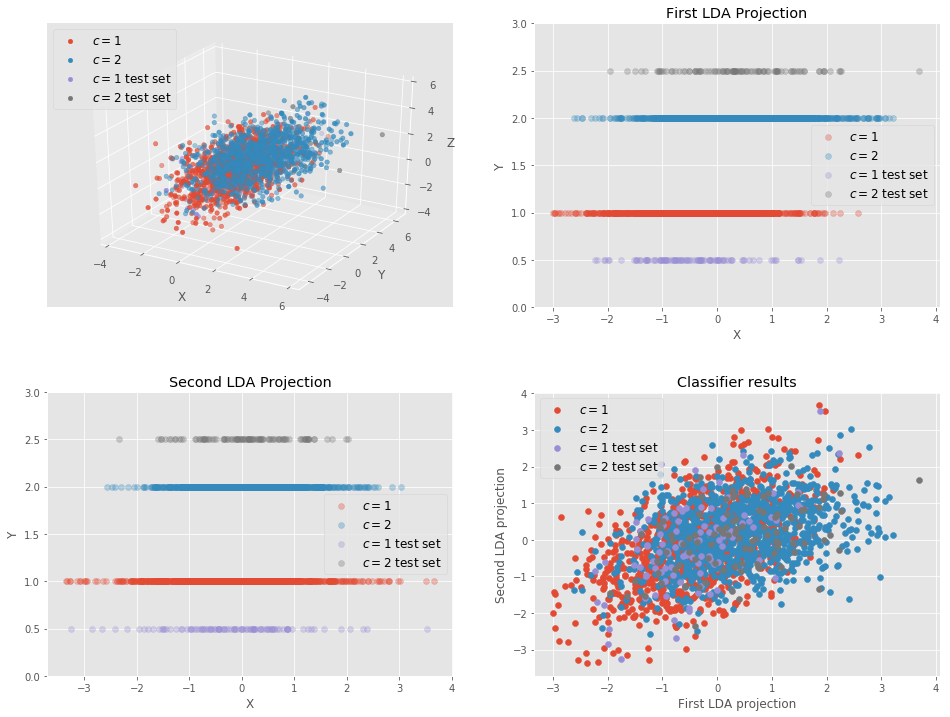

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │   Raw Classifier │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │             0.64 │      0.6715 │        0.561 │              0.647 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │             0.7  │      0.68   │        0.56  │              0.705 │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [10]:
np.random.seed(RANDOM_SEED)

D = 3

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 10 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 10 + np.eye(D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

## Data in $\mathbb{R}^{10}$, full covariance

Raw classifier:
Train rediction accuracy: 1.0
Test Prediction accuracy: 1.0
First LDA projection:
Train prediction accuracy: 1.0
Test prediction accuracy: 1.0
Second LDA projection:
Train rediction accuracy: 0.7925
Test Prediction accuracy: 0.805
Combined classifier:
Train rediction accuracy: 1.0
Test Prediction accuracy: 1.0


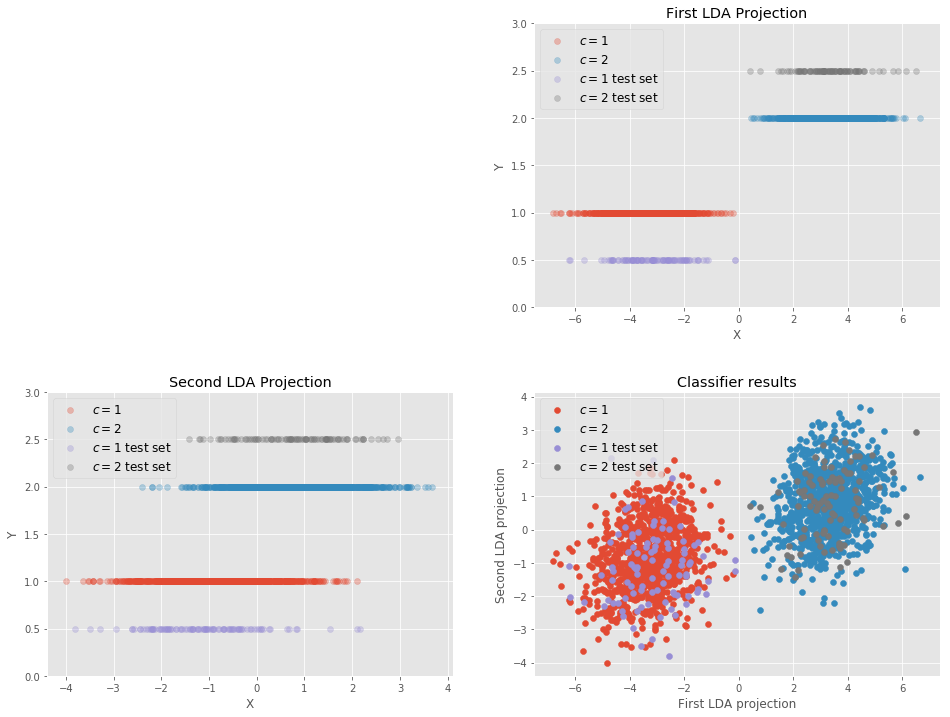

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │   Raw Classifier │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │                1 │           1 │       0.7925 │                  1 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │                1 │           1 │       0.805  │                  1 │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [16]:
np.random.seed(RANDOM_SEED)

D = 10

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

## Data in $\mathbb{R}^{10}$, full covariance

In [ ]:
np.random.seed(RANDOM_SEED)

D = 10

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 10 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 10 + np.eye(D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test)

Raw classifier:
Train rediction accuracy: 1.0
Test Prediction accuracy: 0.86
First LDA projection:
Train prediction accuracy: 0.89
Test prediction accuracy: 0.855
Second LDA projection:
Train rediction accuracy: 0.713
Test Prediction accuracy: 0.69
Combined classifier:
Train rediction accuracy: 0.8895
Test Prediction accuracy: 0.855


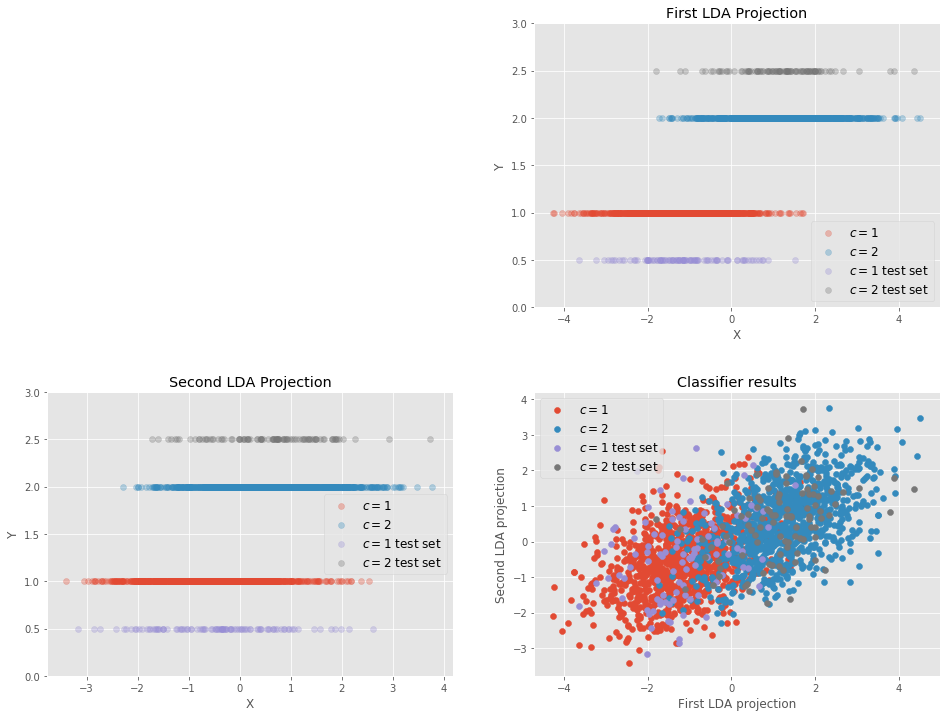

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │   Raw Classifier │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │            0.89  │        1    │        0.713 │             0.8895 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │            0.855 │        0.86 │        0.69  │             0.855  │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [12]:
np.random.seed(RANDOM_SEED)

D = 109

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 10 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 10 + np.eye(D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

## Try the Wisconsin breast cancer dataset

Raw classifier:
Train rediction accuracy: 1.0
Test Prediction accuracy: 0.631578947368
First LDA projection:
Train prediction accuracy: 0.97265625
Test prediction accuracy: 0.877192982456
Second LDA projection:
Train rediction accuracy: 0.96875
Test Prediction accuracy: 0.877192982456
Combined classifier:
Train rediction accuracy: 0.982421875
Test Prediction accuracy: 0.929824561404


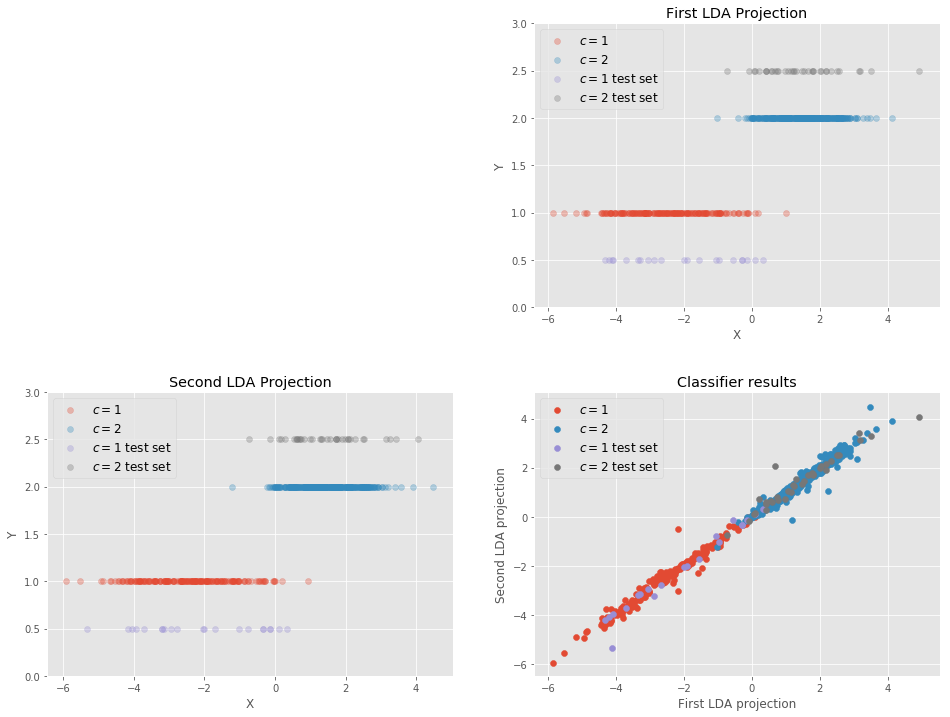

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │   Raw Classifier │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │         1        │    0.972656 │     0.96875  │           0.982422 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │         0.631579 │    0.877193 │     0.877193 │           0.929825 │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [52]:
from sklearn import datasets 
from sklearn.model_selection import train_test_split

wisconsin = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(wisconsin.data, wisconsin.target,
                                                    stratify=wisconsin.target, test_size=0.1)
                                                   # random_state=RANDOM_SEED)

first_train = X_train[y_train == 0]
second_train = X_train[y_train == 1]
first_test = X_test[y_test == 0]
second_test = X_test[y_test == 1]


lda_projection_experiment(first_train, second_train, first_test, second_test,
                         SVC)

## Implementing an `sklearn`-style `IterativeLDA` class

As per http://scikit-learn.org/stable/developers/contributing.html#coding-guidelines

In [31]:
class IterativeLDA:
    def __init__(self, n_components=1):
        self.n_components = n_components
        
    def _ns_using_svd(self, A, eps=1e-15):
        u, s, v = np.linalg.svd(A)
        null_space = v[s.shape[0]:]
        return null_space.T
        
    def fit(self, X, y):
        if X.shape[0] != y.shape[0]:
            raise ValueError('X and y should match on first dimension')
            
        self.ldas_ = []
        self.nullspaces_ = []
        
        current_X = X
        
        for i in range(self.n_components):
            print(i + 1)
            lda = LinearDiscriminantAnalysis(n_components=1)
            lda.fit(current_X, y)
            
            self.ldas_.append(lda)
            
            ns = self._ns_using_svd(lda.coef_)
            self.nullspaces_.append(ns)
         
            current_X = current_X.dot(ns)
        
        return self
    
    def fit_transform(self, X, y):
        if X.shape[0] != y.shape[0]:
            raise ValueError('X and y should match on first dimension')
            
        self.projections_ = []
        self.nullspaces_ = []
        
        current_X = X
        transformed = []
        
        for i in range(self.n_components):
            print(i + 1)
            lda = LinearDiscriminantAnalysis(n_components=1)
            transformed_X = lda.fit_transform(current_X, y)
            transformed.append(transformed_X)
            
            self.ldas_.append(lda)
            
            ns = self._ns_using_svd(lda.coef_)
            self.nullspaces_.append(ns)
         
            current_X = current_X.dot(ns)
        
        return np.hstack(transformed)
        
    def transform(self, X, y=None):
        transformed = []
        current_X = X
        
        for i in range(self.n_components):
            transformed.append(lda.transform(current_X))
            current_X = current_X.dot(self.nullspaces_[i])
            
        return np.hstack(transformed)    

## Experimenting with the cats and dogs dataset

In [5]:
from glob import glob

min_x = (float('Inf'), float('Inf'))
min_y = (float('Inf'), float('Inf'))

for image in glob('./data/iterative_lda/dogs_cats/train/*'):
    shape = io.imread(image).shape
    if shape[0] < min_x[0]:
        min_x = shape
    if shape[1] < min_y[1]:
        min_y = shape

print(min_x)
print(min_y)

(32, 60, 3)
(62, 42, 3)


In [17]:
NEW_IMAGE_SIZE = (64, 64, 3)
TRAIN_SIZE = 1000
TEST_SIZE = 100

dog_image_paths = glob('./data/iterative_lda/dogs_cats/train/dog.*')
cat_image_paths = glob('./data/iterative_lda/dogs_cats/train/dog.*')


def prepare_dataset(paths, train_size=TRAIN_SIZE, test_size=TEST_SIZE, 
                    image_size=NEW_IMAGE_SIZE):
    both_paths = np.random.choice(dog_image_paths, TRAIN_SIZE + TEST_SIZE, False)
    train_paths = both_paths[:train_size]
    test_paths = both_paths[train_size:]
    
    train_images = io.imread_collection(train_paths)
    test_images = io.imread_collection(test_paths)

    resized_train = [transform.resize(image, image_size) for image in train_images]
    resized_test = [transform.resize(image, image_size) for image in test_images]
    
    train_mean = np.mean(resized_train, axis=0)
    centered_train = resized_train - train_mean
    centered_test = resized_test - train_mean
    
    reshaped_train = centered_train.reshape(centered_train.shape[0], -1) 
    reshaped_test = centered_test.reshape(centered_test.shape[0], -1) 

    return reshaped_train, reshaped_test


dog_train, dog_test = prepare_dataset(dog_image_paths)
cat_train, cat_test = prepare_dataset(cat_image_paths)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [32]:
X = np.vstack([dog_train, cat_train])
y = np.asarray([1] * TRAIN_SIZE + [2] * TRAIN_SIZE)

ilda = IterativeLDA(2)
ilda.fit(X, y)
ilda.transform(X)

1


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


2


ValueError: operands could not be broadcast together with shapes (2000,12287) (12288,) 

In [ ]:
X_test = np.vstack([dog_test, cat_test])
y_test = np.asarray([1] *  TEST_SIZE + [2] * TEST_SIZE)

In [26]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [29]:
lda.coef_ 
lda.scalings_

array([[ 0.14147288],
       [ 0.10655826],
       [ 0.04357795],
       ..., 
       [-0.15967264],
       [-0.1114456 ],
       [ 0.01034169]])

Raw classifier:
Train rediction accuracy: 0.512
Test Prediction accuracy: 0.515


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


First LDA projection:
Train prediction accuracy: 0.4945
Test prediction accuracy: 0.555
Second LDA projection:
Train rediction accuracy: 0.496
Test Prediction accuracy: 0.49
Combined classifier:
Train rediction accuracy: 0.5305
Test Prediction accuracy: 0.505


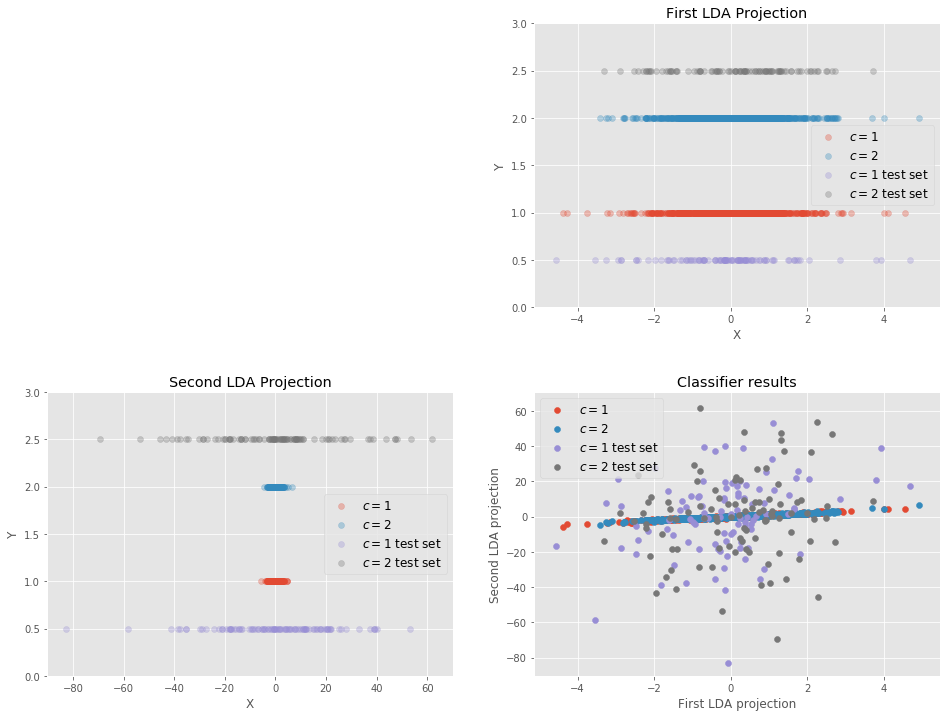

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │   Raw Classifier │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │            0.512 │      0.4945 │        0.496 │             0.5305 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │            0.515 │      0.555  │        0.49  │             0.505  │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛
